In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from data import CleanedData
from models import nn
import sklearn.metrics
import torch
import sklearn.metrics
import matplotlib.pyplot as plt

# For Adaboost
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import pickle

# For KNN
from sklearn.neighbors import KNeighborsClassifier

## Data imputing, cleaning and feature extraction

In [2]:
data = CleanedData(loc='./data/joined.csv.gz', test_ratio=0.2, impute_data=True, convert_non_numerical=True, normalize_data=True, drop_columns=['source', 'Last_Update','province','country','latitude', 'longitude'])

C:\Users\Leo\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Splitting data to test and training data

In [3]:
X_train, y_train = data.training_data
X_test, y_test = data.test_data

In [4]:
X_train.head(5)

,age,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,confirmed_day,in_contact,transformed_Combined_Key,transformed_sex
250913,40.069437,22.694884,71.590923,11.698043,8.097426,11.522618,9.685083,5.238571,2.730687,151.0,0.0,169.0,2.0
77220,41.918000,28.646519,77.108980,12.383499,8.498418,12.214393,10.381273,7.151806,2.054617,143.0,0.0,116.0,2.0
385006,40.255102,19.449759,76.108221,13.970372,10.366939,13.634507,12.615772,6.854431,2.723007,131.0,0.0,252.0,2.0
234392,41.580081,22.694884,71.590923,11.698043,8.097426,11.522618,9.685083,5.238571,2.730687,128.0,0.0,169.0,2.0
403638,38.615530,26.925425,80.560982,12.744867,8.490644,12.506525,11.124686,4.970505,1.420411,148.0,0.0,468.0,2.0


## Model 1 variations, neural network with different hyperparameters and architectures

In [5]:
models = []
trained_models = 13
for i in range(trained_models):
    models.append(nn.network_1())
    nn.load_model(models[i], f'./models/weights/model_{i}.pth')

## Accuracy of each model on training and validation data

In [6]:
for i in range(trained_models):
    print(f'training accuracy of model_{i+1}: {nn.eval(models[i], X_train, y_train):.2f}%')
    print(f'validation accuracy of model_{i+1}: {nn.eval(models[i], X_test, y_test):.2f}%')

training accuracy of model_1: 81.02%
validation accuracy of model_1: 81.05%
training accuracy of model_2: 84.37%
validation accuracy of model_2: 84.48%
training accuracy of model_3: 82.91%
validation accuracy of model_3: 82.95%
training accuracy of model_4: 82.89%
validation accuracy of model_4: 82.95%
training accuracy of model_5: 83.04%
validation accuracy of model_5: 83.06%
training accuracy of model_6: 83.12%
validation accuracy of model_6: 83.17%
training accuracy of model_7: 82.17%
validation accuracy of model_7: 82.27%
training accuracy of model_8: 84.36%
validation accuracy of model_8: 84.48%
training accuracy of model_9: 84.47%
validation accuracy of model_9: 84.54%
training accuracy of model_10: 84.79%
validation accuracy of model_10: 84.91%
training accuracy of model_11: 84.93%
validation accuracy of model_11: 85.03%
training accuracy of model_12: 84.76%
validation accuracy of model_12: 84.86%
training accuracy of model_13: 84.84%
validation accuracy of model_13: 84.90%


## Making predictions

In [7]:
models_training_preds = []
models_validation_preds = []
for i in range(trained_models):
    models_training_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_train.values).float()), dim=1), dim=1))
    models_validation_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_test.values).float()), dim=1), dim=1))

## F-2 scores of different models 

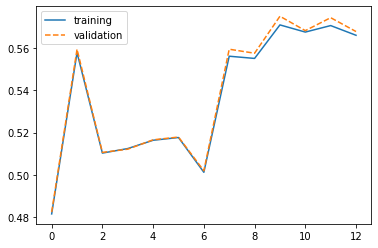

In [8]:
fscore_training = []
fscore_validation = []
for i in range(trained_models):
    fscore_training.append(sklearn.metrics.fbeta_score(y_train, models_training_preds[i], beta=2, average="macro"))
    fscore_validation.append(sklearn.metrics.fbeta_score(y_test, models_validation_preds[i], beta=2, average="macro"))

plt.plot(fscore_training,)
plt.plot(fscore_validation,linestyle='dashed')
plt.legend(['training', 'validation'])

In [9]:
sklearn.metrics.fbeta_score(y_test, models_validation_preds[i], beta=2, average=None)

array([0.08316633, 0.92135643, 0.99425055, 0.27215598])

In [10]:
data.encoder.classes_.tolist()

['deceased', 'hospitalized', 'nonhospitalized', 'recovered']

## Confusion matrices for the best performing model

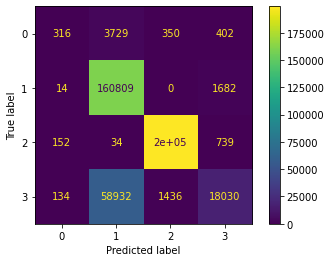

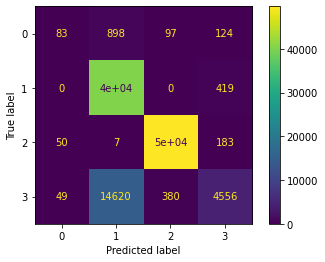

In [11]:
conf_matrix_train = sklearn.metrics.confusion_matrix(y_train.values, models_training_preds[i])
conf_matrix_val = sklearn.metrics.confusion_matrix(y_test.values, models_validation_preds[i])

sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_train).plot()
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_val).plot()

## Model 2: Adaboost

In [12]:
# adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 20),n_estimators = 25, learning_rate = 1)
# adaboost.fit(X_train, y_train)
with open('./data/adaboost_model.pkl', 'rb') as f:
    adaboost = pickle.load(f)

### Training Set Accuracy Score

In [13]:
adaboost.score(X_train,y_train)

0.8651315715698654

### Test set Accuracy Score

In [14]:
adaboost.score(X_test,y_test)

0.865703776800933

### Confusion Matrices

#### Test Data Set

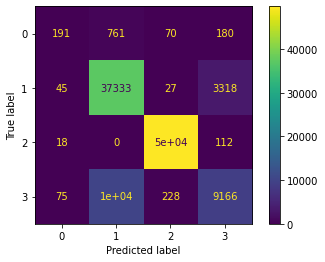

In [15]:
y_test_pred = adaboost.predict(X_test)
test_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_matrix).plot()

#### Training Data Set

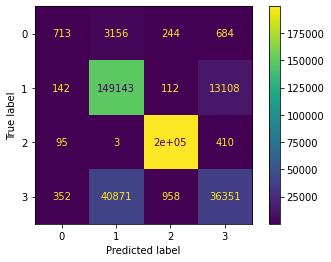

In [16]:
y_train_pred = adaboost.predict(X_train)
train_matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_matrix).plot()

####  F-2 Scores

In [17]:
print(f'F_2 score of Adaboost on training dataset: {sklearn.metrics.fbeta_score(y_train, y_train_pred, beta=2, average="macro"):.4f}')
print(f'F_2 score of Adaboost on validation dataset: {sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average="macro"):.4f}')

F_2 score of Adaboost on training dataset: 0.6384
F_2 score of Adaboost on validation dataset: 0.6423


In [18]:
sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average=None)

array([0.18590617, 0.88415703, 0.99661858, 0.50254397])

In [19]:
import matplotlib.pyplot as plts

ranges = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45]
training_accuracy = list()
test_accuracy = list()
training_f2score = list()
test_f2score = list()

for i in ranges:
    adaboost_overfit = AdaBoostClassifier(DecisionTreeClassifier(max_depth = i),n_estimators = 25, learning_rate = 1)
    adaboost_overfit.fit(X_train,y_train) 
    training_accuracy.append(adaboost_overfit.score(X_train,y_train))
    test_accuracy.append(adaboost_overfit.score(X_test,y_test))
    y_test_predict = adaboost_overfit.predict(X_test)
    y_train_predict = adaboost_overfit.predict(X_train)
    training_f2score.append(sklearn.metrics.fbeta_score(y_train, y_train_predict, beta=2, average="macro"))
    test_f2score.append(sklearn.metrics.fbeta_score(y_test, y_test_predict, beta=2, average="macro"))

# Scores for loaded tree size n = 50 Adaboost Classifier
training_accuracy.append(adaboost.score(X_train,y_train))
test_accuracy.append(adaboost.score(X_test,y_test))
training_f2score.append(sklearn.metrics.fbeta_score(y_train, y_train_pred, beta=2, average="macro"))
test_f2score.append(sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average="macro"))

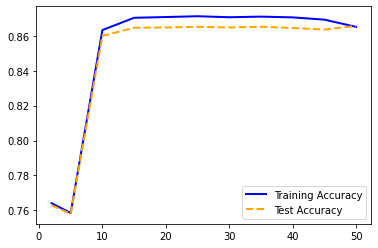

In [20]:
ranges.append(50)
dict_accuracy = {'Tree_Size': ranges, 'Training_Accuracy': training_accuracy, 'Test_Accuracy': test_accuracy, 'Training_F2': training_f2score, 'Test_F2': test_f2score}  
df = pd.DataFrame(dict_accuracy)
plts.plot( 'Tree_Size', 'Training_Accuracy', data=df, marker='', color='blue', linewidth=2, label="Training Accuracy")
plts.plot( 'Tree_Size', 'Test_Accuracy', data=df, marker='', color='orange', linewidth=2, linestyle='dashed', label="Test Accuracy")
plts.legend()

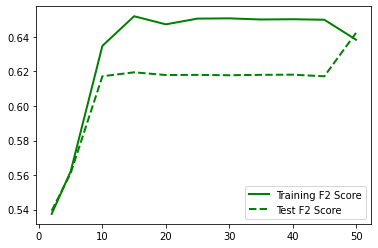

In [21]:
plts.plot( 'Tree_Size', 'Training_F2', data=df, marker='', color='green', linewidth=2, label="Training F2 Score")
plts.plot( 'Tree_Size', 'Test_F2', data=df, marker='', color='green', linewidth=2, linestyle='dashed', label="Test F2 Score")
plts.legend()

## Model 3: K-Nearest Neighbors

In [22]:
#knn = KNeighborsClassifier(n_neighbors=10)
#knn.fit(X_train, y_train)
with open('./data/knn_model.pkl', 'rb') as knn_file:
    knn = pickle.load(knn_file)
knn

KNeighborsClassifier(n_neighbors=40, p=1)

#### Training Set Accuracy Score

In [23]:
knn.score(X_train,y_train)

0.8628304988573133

#### Test Set Accuracy Score

In [24]:
knn.score(X_test,y_test)

0.8635148470440477

#### Test Data Set

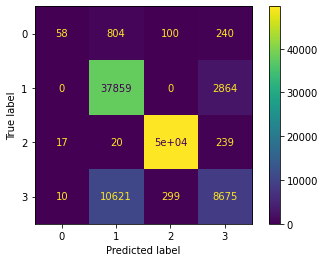

In [25]:
y_test_pred = knn.predict(X_test)
test_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_matrix).plot()

#### Training Dataset

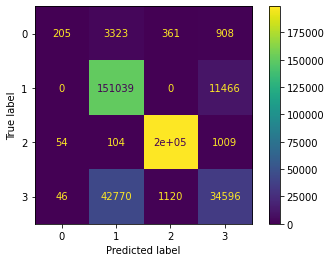

In [26]:
y_train_pred = knn.predict(X_train)
train_matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_matrix).plot()

### F-2 Scores

In [27]:
print(f'F_2 score of KNN on training dataset: {sklearn.metrics.fbeta_score(y_train, y_train_pred, beta=2, average="macro"):.4f}')
print(f'F_2 score of KNN on validation dataset: {sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average="macro"):.4f}')

F_2 score of KNN on training dataset: 0.6039
F_2 score of KNN on validation dataset: 0.6062


### Overfitting graphs

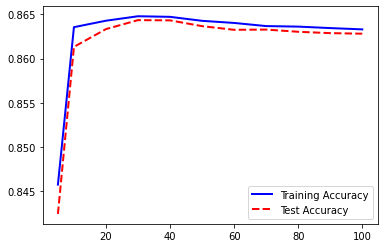

In [28]:
dist_forumla = 1 # Manhattan
#dist_forumla = 2 # Euclidean
#dist_forumla = 3 # Minkowski

ranges = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
training_accuracy = list()
test_accuracy = list()
training_f2score = list()
test_f2score = list()

for i in ranges:
    knn = KNeighborsClassifier(n_neighbors=i, p=dist_forumla)
    knn.fit(X_train,y_train) 
    training_accuracy.append(knn.score(X_train,y_train))
    test_accuracy.append(knn.score(X_test,y_test))
    y_test_predict = knn.predict(X_test)
    y_train_predict = knn.predict(X_train)
    training_f2score.append(sklearn.metrics.fbeta_score(y_train, y_train_predict, beta=2, average="macro"))
    test_f2score.append(sklearn.metrics.fbeta_score(y_test, y_test_predict, beta=2, average="macro"))


dict_accuracy = {'K_Values': ranges, 'Training_Accuracy': training_accuracy, 'Test_Accuracy': test_accuracy, 'Training_F2': training_f2score, 'Test_F2': test_f2score}  
df = pd.DataFrame(dict_accuracy)
plts.plot( 'K_Values', 'Training_Accuracy', data=df, marker='', color='blue', linewidth=2, label="Training Accuracy")
plts.plot( 'K_Values', 'Test_Accuracy', data=df, marker='', color='red', linewidth=2, linestyle='dashed', label="Test Accuracy")
plts.legend()
